In [ ]:
# !pip uninstall keras tensorflow
# !pip install keras tensorflow


Found existing installation: keras 2.15.0
Uninstalling keras-2.15.0:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/keras-2.15.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/keras/*
Proceed (Y/n)? ERROR: Operation cancelled by user
ERROR: Operation cancelled by user


In [ ]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.layers import SeparableConv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# If the URL doesn't work, visit https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765
# And right click on the 'Download Manually' link to get a new URL to the dataset

# Note: This is a very large dataset and will take some time to download

!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2023-12-21 08:45:46--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 184.25.209.13, 2600:1409:9800:1391::317f
Connecting to download.microsoft.com (download.microsoft.com)|184.25.209.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.67M   111MB/s    in 6.3s    

2023-12-21 08:45:52 (124 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824887076/824887076]



In [ ]:
# grader-required-cell

source_path = '/tmp/PetImages'

source_path_dogs = os.path.join(source_path, 'Dog')
source_path_cats = os.path.join(source_path, 'Cat')

# Deletes all non-image files (there are two .db files bundled into the dataset)
!find /tmp/PetImages/ -type f ! -name "*.jpg" -exec rm {} +

# os.listdir returns a list containing all files under the given path
print(f"There are {len(os.listdir(source_path_dogs))} images of dogs.")
print(f"There are {len(os.listdir(source_path_cats))} images of cats.")

There are 12500 images of dogs.
There are 12500 images of cats.


In [ ]:
# grader-required-cell

# Define root directory
root_dir = '/tmp/cats-v-dogs'

# Empty directory to prevent FileExistsError is the function is run several times
if os.path.exists(root_dir):
  shutil.rmtree(root_dir)

# GRADED FUNCTION: create_train_val_dirs
def create_train_val_dirs(root_path):
  """
  Creates directories for the train and test sets

  Args:
    root_path (string) - the base directory path to create subdirectories from

  Returns:
    None
  """

  ### START CODE HERE

  # HINT:
  # Use os.makedirs to create your directories with intermediate subdirectories
  # Don't hardcode the paths. Use os.path.join to append the new directories to the root_path parameter

  os.makedirs(os.path.join(root_path, 'training'))
  os.makedirs(os.path.join(f'{root_path}/training', 'dogs'))
  os.makedirs(os.path.join(f'{root_path}/training', 'cats'))
  os.makedirs(os.path.join(root_path, 'validation'))
  os.makedirs(os.path.join(f'{root_path}/validation', 'dogs'))
  os.makedirs(os.path.join(f'{root_path}/validation', 'cats'))


  ### END CODE HERE


try:
  create_train_val_dirs(root_path=root_dir)
except FileExistsError:
  print("You should not be seeing this since the upper directory is removed beforehand")

In [ ]:
# grader-required-cell

# Test your create_train_val_dirs function

for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

/tmp/cats-v-dogs/validation
/tmp/cats-v-dogs/training
/tmp/cats-v-dogs/validation/dogs
/tmp/cats-v-dogs/validation/cats
/tmp/cats-v-dogs/training/dogs
/tmp/cats-v-dogs/training/cats


In [ ]:
# grader-required-cell

# GRADED FUNCTION: split_data
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):
  """
  Splits the data into train and test sets

  Args:
    SOURCE_DIR (string): directory path containing the images
    TRAINING_DIR (string): directory path to be used for training
    VALIDATION_DIR (string): directory path to be used for validation
    SPLIT_SIZE (float): proportion of the dataset to be used for training

  Returns:
    None
  """
  ### START CODE HERE
   # Shuffle list
  shuffled_source_dir = random.sample(os.listdir(SOURCE_DIR), len(os.listdir(SOURCE_DIR)))

  # Find total number of files in training dir
  training_number_files = int(len(shuffled_source_dir) * SPLIT_SIZE)

  i = 0
  target = TRAINING_DIR

  for item in shuffled_source_dir:
    item_source = os.path.join(SOURCE_DIR, item)
    if os.path.getsize(item_source) == 0:
      print(f'{item} is zero length, so ignoring.')
    else:
      copyfile(item_source, os.path.join(target, item))
      i += 1

    # Switch copy target to validation
    if i == training_number_files:
      target = VALIDATION_DIR


  ### END CODE HERE

In [ ]:
# grader-required-cell

# Test your split_data function

# Define paths
CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"

TRAINING_DIR = "/tmp/cats-v-dogs/training/"
VALIDATION_DIR = "/tmp/cats-v-dogs/validation/"

TRAINING_CATS_DIR = os.path.join(TRAINING_DIR, "cats/")
VALIDATION_CATS_DIR = os.path.join(VALIDATION_DIR, "cats/")

TRAINING_DOGS_DIR = os.path.join(TRAINING_DIR, "dogs/")
VALIDATION_DOGS_DIR = os.path.join(VALIDATION_DIR, "dogs/")

# Empty directories in case you run this cell multiple times
if len(os.listdir(TRAINING_CATS_DIR)) > 0:
  for file in os.scandir(TRAINING_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_DOGS_DIR)) > 0:
  for file in os.scandir(TRAINING_DOGS_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_CATS_DIR)) > 0:
  for file in os.scandir(VALIDATION_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_DOGS_DIR)) > 0:
  for file in os.scandir(VALIDATION_DOGS_DIR):
    os.remove(file.path)

# Define proportion of images used for training
split_size = .9

# Run the function
# NOTE: Messages about zero length images should be printed out
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, VALIDATION_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, VALIDATION_DOGS_DIR, split_size)

# Your function should perform copies rather than moving images so original directories should contain unchanged images
print(f"\n\nOriginal cat's directory has {len(os.listdir(CAT_SOURCE_DIR))} images")
print(f"Original dog's directory has {len(os.listdir(DOG_SOURCE_DIR))} images\n")

# Training and validation splits. Check that the number of images matches the expected output.
print(f"There are {len(os.listdir(TRAINING_CATS_DIR))} images of cats for training")
print(f"There are {len(os.listdir(TRAINING_DOGS_DIR))} images of dogs for training")
print(f"There are {len(os.listdir(VALIDATION_CATS_DIR))} images of cats for validation")
print(f"There are {len(os.listdir(VALIDATION_DOGS_DIR))} images of dogs for validation")

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


Original cat's directory has 12500 images
Original dog's directory has 12500 images

There are 11250 images of cats for training
There are 11250 images of dogs for training
There are 1249 images of cats for validation
There are 1249 images of dogs for validation


In [ ]:
# grader-required-cell

# GRADED FUNCTION: train_val_generators
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  """
  Creates the training and validation data generators

  Args:
    TRAINING_DIR (string): directory path containing the training images
    VALIDATION_DIR (string): directory path containing the testing/validation images

  Returns:
    train_generator, validation_generator - tuple containing the generators
  """
  ### START CODE HERE

  # Instantiate the ImageDataGenerator class (don't forget to set the arguments to augment the images)
  train_datagen = ImageDataGenerator(rescale= 1./255.,
                                     rotation_range= 40,
                                     width_shift_range= 0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode="nearest")

  # Apply the augmentation to the training generator
  train_generator = train_datagen.flow_from_directory(
      directory=TRAINING_DIR,
      target_size=(150, 150),
      batch_size=32,
      class_mode='binary'
  )

  # Pass in the appropriate arguments to the flow_from_directory method
  # train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
  #                                                     batch_size=45,
  #                                                     class_mode="binary",
  #                                                     target_size=(150, 150))

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  validation_datagen = ImageDataGenerator(rescale= 1./255.)

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=5,
                                                                class_mode="binary",
                                                                target_size=(150, 150))
  ### END CODE HERE
  return train_generator, validation_generator

In [ ]:
# grader-required-cell

# Test your generators
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 22500 images belonging to 2 classes.
Found 2498 images belonging to 2 classes.


In [ ]:
def create_model():
    model = tf.keras.models.Sequential([
        # Emphasize depthwise separable convolutions for efficiency
        SeparableConv2D(16, 3, activation='relu', input_shape=(150, 150, 3)),  # Update input_shape
        MaxPooling2D(2, 2),
        SeparableConv2D(32, 3, activation='relu'),
        MaxPooling2D(2, 2),
        # Consider LeakyReLU or ELU activations for potential performance gains
        SeparableConv2D(64, 3, activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        # Reduce the size of the dense layers
        Dense(64, activation='relu'),
        Dropout(0.2),  # Apply dropout for regularization
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


In [ ]:
# Get the untrained model
model = create_model()

# Train the model with early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(train_generator,
                    epochs=15,
                    verbose=1,
                    validation_data=validation_generator,
                    callbacks=[early_stopping])



Epoch 1/15
693/704 [============================>.] - ETA: 2s - loss: 0.6593 - accuracy: 0.6043

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


704/704 [==============================] - 159s 220ms/step - loss: 0.6593 - accuracy: 0.6036 - val_loss: 0.6201 - val_accuracy: 0.6469
Epoch 2/15
704/704 [==============================] - 157s 223ms/step - loss: 0.6141 - accuracy: 0.6608 - val_loss: 0.5759 - val_accuracy: 0.7018
Epoch 3/15
704/704 [==============================] - 154s 219ms/step - loss: 0.5919 - accuracy: 0.6843 - val_loss: 0.5490 - val_accuracy: 0.7262
Epoch 4/15
704/704 [==============================] - 158s 224ms/step - loss: 0.5755 - accuracy: 0.6967 - val_loss: 0.5145 - val_accuracy: 0.7422
Epoch 5/15
704/704 [==============================] - 167s 238ms/step - loss: 0.5595 - accuracy: 0.7088 - val_loss: 0.5085 - val_accuracy: 0.7502
Epoch 6/15
704/704 [==============================] - 154s 218ms/step - loss: 0.5474 - accuracy: 0.7222 - val_loss: 0.5185 - val_accuracy: 0.7418
Epoch 7/15
704/704 [==============================] - 153s 217ms/step - loss: 0.5378 - accuracy: 0.7262 - val_loss: 0.5028 - val_accura

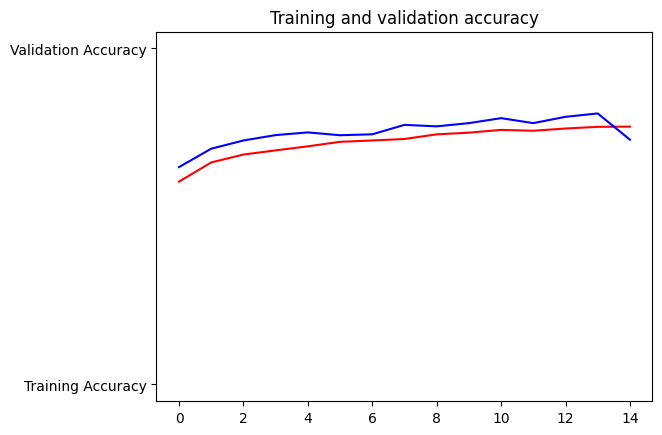

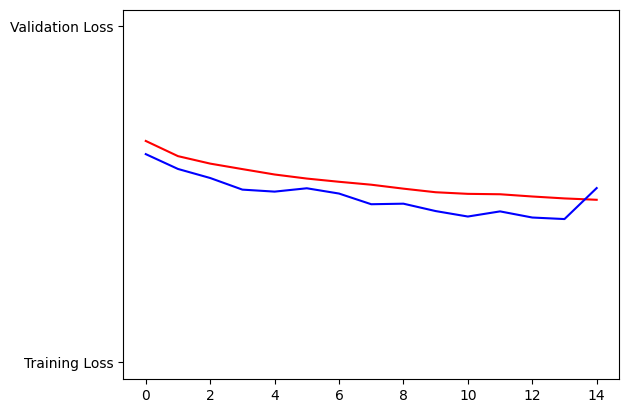

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

In [ ]:
# def download_history():
#   import pickle
#   from google.colab import files

#   with open('history_augmented.pkl', 'wb') as f:
#     pickle.dump(history.history, f)

#   files.download('history_augmented.pkl')

# download_history()

# Download the model for deployment
model.save('cats_vs_dogs_model.h5')

In [ ]:
!ls

cats_vs_dogs_model.h5  sample_data
